In [1]:
from pyiron_workflow import Workflow
from typing import Optional

In [2]:
from python.pyironflow import PyironFlow
import pyiron_nodes.atomistic as pna
import pyiron_nodes.fenicsx as pnf

2024-09-21 21:54:36,824 - pyiron_log - WARNING - pyiron found a 'templates' folder in the /home/tlakshmi/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().
2024-09-21 21:54:36,824 - pyiron_log - WARNING - pyiron found a 'templates' folder in the /home/tlakshmi/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().


In [3]:
wf = Workflow("multiscale_linear_elasticity")

wf.ase_emt_engine = pna.engine.ase.EMT()
wf.structure = pna.structure.build.Bulk(name='Au', cubic=True)
wf.elastic_calc_params = pna.property.elastic.InputElasticTensor(num_of_point=7, eps_range=0.005, sqrt_eta=True, fit_order=3)
wf.elastic_constants = pna.property.elastic.ElasticConstants(wf.structure, wf.ase_emt_engine, wf.elastic_calc_params)
wf.rotated_elastic_tensor = pna.property.elastic.rotate_elasticity_tensor(wf.elastic_constants, crystal='fcc', x_indices="0 -1 1", y_indices="1 0 0", z_indices="0 1 1")

wf.bar_geom_params = pnf.geometries.three_d_geometries.bar_parameters(length=3.0, width=0.2, depth=0.2, density=1.0)
wf.bar_domain = pnf.geometries.three_d_geometries.create_bar(x0=0, y0=0, z0=0, min_mesh=0.03, max_mesh=0.03, parameters=wf.bar_geom_params)
wf.vector_function_space = pnf.function_spaces.general_function_spaces.create_vector_function_space(wf.bar_domain, "Lagrange", 1)
wf.init_mesh_plotter_obj= pnf.mesh_visualization.pyvista_viz.plot_init_mesh_object(wf.vector_function_space)
wf.bc_left = pnf.boundary_conditions.scalar_geometric.three_d_scalar_dirichlet(function_space=wf.vector_function_space, bc_function="np.isclose(x[0], 0)",
                                                                               value_x=0, value_y=0, value_z=0
                                                                              )
wf.bc_right = pnf.boundary_conditions.scalar_geometric.three_d_scalar_dirichlet(function_space=wf.vector_function_space, bc_function="np.isclose(x[0], 3)",
                                                                                value_x=0, value_y=0, value_z=0
                                                                               )
wf.bc_array = pnf.boundary_conditions.scalar_geometric.collect_bcs(bc1=wf.bc_left, bc2=wf.bc_right)
wf.solution_vector = pnf.solvers.linear_elasticity.macro_three_d_linear_elasticity(domain=wf.bar_domain, function_space=wf.vector_function_space, 
                                                                                   bcs_array=wf.bc_array, traction_x=0, traction_y=0, 
                                                                                   traction_z=0, body_force_x=0, body_force_y=0, body_force_z=0, 
                                                                                   gravity_factor=0.015, elasticity_tensor=wf.rotated_elastic_tensor,
                                                                                   parameters=wf.bar_geom_params
                                                                                  )
wf.vonMises_plotter_obj = pnf.mesh_visualization.pyvista_viz.plot_three_d_vonMises_object(domain=wf.bar_domain,
                                                                                          function_space=wf.vector_function_space,
                                                                                          solution_vector=wf.solution_vector,
                                                                                          elasticity_tensor=wf.rotated_elastic_tensor, 
                                                                                          warp_factor=60.0, show_undeformed=False,                                                                                         
                                                                                         )

wf()

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000696426s, CPU 0.000866s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : [ 90%

{'init_mesh_plotter_obj__plotter': <pyvista.plotting.plotter.Plotter at 0x7ebd604be650>,
 'vonMises_plotter_obj__plotter': <pyvista.plotting.plotter.Plotter at 0x7ebd53b37450>}

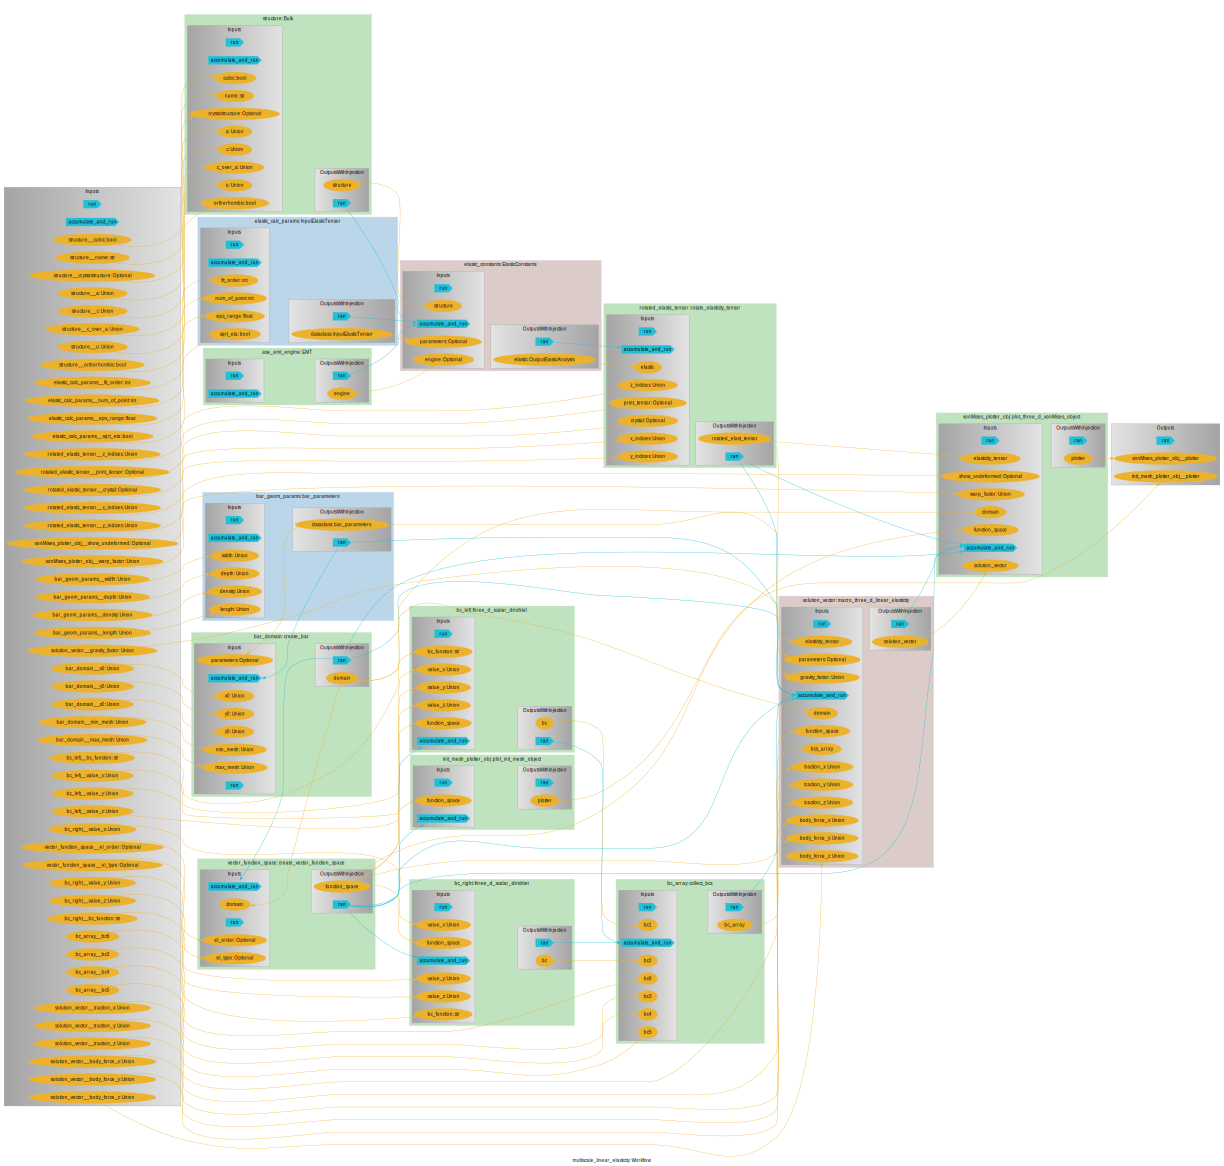

In [4]:
wf.draw(size=(17,17))
#pic = wf.draw(size=(15,15))
#pic.render(outfile='workflow.svg')

In [5]:
pf = PyironFlow([wf])
#pf = PyironFlow()
pf.gui

In [6]:
wf_from_gui = pf.get_workflow()

In [9]:
wf_from_gui.init_mesh_plotter_obj.pull().show()

A view with name (P_0x7ebd689f7c10_3) is already registered
 => returning previous one


Widget(value='<iframe src="http://localhost:37253/index.html?ui=P_0x7ebd689f7c10_3&reconnect=auto" class="pyvi…

In [10]:
wf_from_gui.vonMises_plotter_obj.pull().show()

A view with name (P_0x7ebd689df7d0_5) is already registered
 => returning previous one


Widget(value='<iframe src="http://localhost:37253/index.html?ui=P_0x7ebd689df7d0_5&reconnect=auto" class="pyvi…